In [ ]:
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from scipy.spatial import KDTree
import numpy as np
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import pytz
import glob

In [ ]:
#one file has wrong name, rename it first.
old_name = '202302-captialbikeshare-tripdata.csv'
new_name = '202302-capitalbikeshare-tripdata.csv'

# Renaming the file
if os.path.exists(old_name):
    os.rename(old_name, new_name)
    print(f"Renamed '{old_name}' to '{new_name}'")

Renamed '202302-captialbikeshare-tripdata.csv' to '202302-capitalbikeshare-tripdata.csv'


In [ ]:
####################################################################################
########### This cell cleans all the trip files ####################################
########### This cell will take around 2m30s to load the dataset####################
####################################################################################

months = [str(i).zfill(2) for i in range(1, 13)]
file_list = [f'2023{month}-capitalbikeshare-tripdata.csv' for month in months]

for file in file_list:
    # Step 1: Read the CSV file
    df = pd.read_csv(file)

    # Convert 'started_at' and 'ended_at' columns to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])

    # Calculate the duration in seconds and create a new column 'duration'
    df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

    # Remove rows with any missing values in the specified columns
    df = df.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'])

    # Remove rows where 'duration' is greater than 12 hours (43200 seconds) or less than 2 minutes (120 seconds)
    df = df[(df['duration'] <= 43200) & (df['duration'] >= 120)]

    # Convert datetime columns to object type
    df['started_at'] = df['started_at'].astype(object)
    df['ended_at'] = df['ended_at'].astype(object)

    # Save the cleaned DataFrame to a new CSV file
    cleaned_file = file.replace('.csv', '_cleaned1.csv')
    df.to_csv(cleaned_file, index=False)

    print(f"Processed {file} and saved cleaned data to {cleaned_file}")


Processed 202301-capitalbikeshare-tripdata.csv and saved cleaned data to 202301-capitalbikeshare-tripdata_cleaned1.csv
Processed 202302-capitalbikeshare-tripdata.csv and saved cleaned data to 202302-capitalbikeshare-tripdata_cleaned1.csv
Processed 202303-capitalbikeshare-tripdata.csv and saved cleaned data to 202303-capitalbikeshare-tripdata_cleaned1.csv
Processed 202304-capitalbikeshare-tripdata.csv and saved cleaned data to 202304-capitalbikeshare-tripdata_cleaned1.csv
Processed 202305-capitalbikeshare-tripdata.csv and saved cleaned data to 202305-capitalbikeshare-tripdata_cleaned1.csv
Processed 202306-capitalbikeshare-tripdata.csv and saved cleaned data to 202306-capitalbikeshare-tripdata_cleaned1.csv
Processed 202307-capitalbikeshare-tripdata.csv and saved cleaned data to 202307-capitalbikeshare-tripdata_cleaned1.csv
Processed 202308-capitalbikeshare-tripdata.csv and saved cleaned data to 202308-capitalbikeshare-tripdata_cleaned1.csv
Processed 202309-capitalbikeshare-tripdata.csv a

In [ ]:
####################################################################################
#################### This cell will take around 50h to process!####################
####################################################################################

# Read road shapefile, its CRS is EPSG:4326
road_network = gpd.read_file('Roadway_Block.shp')

# Build a road network diagram
G = nx.Graph()
nodes = []

for _, row in road_network.iterrows():
    geom = row.geometry
    if geom and geom.geom_type == 'LineString':
        coords = list(geom.coords)
        nodes.extend(coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], weight=LineString([coords[i], coords[i + 1]]).length)

# Remove duplicate nodes and create KDTree
unique_nodes = list(set(nodes))
node_coords = np.array(unique_nodes)
kdtree = KDTree(node_coords[:, :2])

# Function to find the nearest node
def get_nearest_node(point, kdtree, node_coords):
    dist, idx = kdtree.query([point.x, point.y])
    return tuple(node_coords[idx])

# Function to process a batch
def process_batch(batch_df):
    paths = []
    for _, row in batch_df.iterrows():
        start_point = Point(row['start_lng'], row['start_lat'])
        end_point = Point(row['end_lng'], row['end_lat'])

        if start_point.is_empty or end_point.is_empty:
            paths.append(None)
            continue

        start_node = get_nearest_node(start_point, kdtree, node_coords)
        end_node = get_nearest_node(end_point, kdtree, node_coords)

        if start_node and end_node:
            try:
                shortest_path_nodes = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
                if len(shortest_path_nodes) > 1:
                    shortest_path = LineString(shortest_path_nodes)
                    paths.append(shortest_path)
                else:
                    paths.append(None)
            except nx.NetworkXNoPath:
                paths.append(None)
        else:
            paths.append(None)
    return batch_df.assign(geometry=paths)

# Functions for processing batches in parallel
def process_batches_in_parallel(df, batch_size, num_workers, month):
    num_batches = len(df) // batch_size + 1
    futures = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for i in range(num_batches):
            batch_df = df.iloc[i * batch_size: (i + 1) * batch_size]
            print(f"Submitting batch {i + 1} of {num_batches}...")
            futures.append(executor.submit(process_batch, batch_df))

        for i, future in enumerate(as_completed(futures)):
            batch_result = future.result()
            # Save each batch as GeoJSON
            batch_output_file = f'capitalbike_shortest_paths_{month}_{i + 1}.geojson'
            gdf_batch = gpd.GeoDataFrame(batch_result, geometry='geometry')
            gdf_batch.crs = "EPSG:4326"
            gdf_batch.to_file(batch_output_file, driver='GeoJSON')
            print(f"Batch {i + 1} processed and saved to {batch_output_file}")

# Merge GeoJSON files
def merge_geojson(file_paths, output_file_path):
    gdf_list = [gpd.read_file(file) for file in file_paths]
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
    combined_gdf.to_file(output_file_path, driver='GeoJSON')
    print(f"GeoJSON files have been successfully merged into {output_file_path}")

# Function to clean and calculate new columns, and then save as GeoJSON
def clean_and_calculate_columns(combined_gdf, road_block_gdf, month):
    combined_gdf = combined_gdf.to_crs(epsg=3559)
    combined_gdf['length'] = combined_gdf.geometry.length
    combined_gdf['speed'] = combined_gdf['length'] / combined_gdf['duration']
    cleaned_gdf = combined_gdf[(combined_gdf['speed'] >= 1) & (combined_gdf['speed'] <= 9)].copy()
    cleaned_gdf['started_at'] = pd.to_datetime(cleaned_gdf['started_at'])
    cleaned_gdf['Y_or_D'] = cleaned_gdf['started_at'].dt.weekday.apply(lambda x: 'Y' if x < 5 else 'D')

    def determine_period(hour):
        if 6 <= hour <= 9:
            return 1
        elif 10 <= hour <= 15:
            return 2
        elif 16 <= hour <= 19:
            return 3
        else:
            return 4

    cleaned_gdf['period'] = cleaned_gdf['started_at'].dt.hour.apply(determine_period)
    cleaned_gdf['hour'] = cleaned_gdf['started_at'].dt.hour
    cleaned_gdf['started_at'] = cleaned_gdf['started_at'].astype(str)
    cleaned_gdf['ended_at'] = cleaned_gdf['ended_at'].astype(str)

    output_file_path_clean = f'capitalbike_tra{month}_clean.geojson'
    cleaned_gdf.to_file(output_file_path_clean, driver='GeoJSON')
    print(f"Cleaned GeoJSON saved to {output_file_path_clean}")

# List of CSV files to process
files = [
    '202301-capitalbikeshare-tripdata_cleaned1.csv',
    '202302-capitalbikeshare-tripdata_cleaned1.csv',
    '202303-capitalbikeshare-tripdata_cleaned1.csv',
    '202304-capitalbikeshare-tripdata_cleaned1.csv',
    '202305-capitalbikeshare-tripdata_cleaned1.csv',
    '202306-capitalbikeshare-tripdata_cleaned1.csv',
    '202307-capitalbikeshare-tripdata_cleaned1.csv',
    '202308-capitalbikeshare-tripdata_cleaned1.csv',
    '202309-capitalbikeshare-tripdata_cleaned1.csv',
    '202310-capitalbikeshare-tripdata_cleaned1.csv',
    '202311-capitalbikeshare-tripdata_cleaned1.csv',
    '202312-capitalbikeshare-tripdata_cleaned1.csv'
]

for csv_file in files:
    # # clean the previous raw data once per file, you can uncomment them if you don't have enough RAM
    # raw_files = glob.glob('capitalbike_shortest_paths_*.geojson')
    # for raw_file in raw_files:
    #     os.remove(raw_file)
    #     print(f"Deleted: {raw_file}")

    month = csv_file.split('-')[0][4:]  # Extract month from file name
    print(f"Processing {csv_file} for month {month}...")
    df = pd.read_csv(csv_file)
    process_batches_in_parallel(df, batch_size=100000, num_workers=4, month=month)

    # Merge GeoJSON files
    file_paths = [f'capitalbike_shortest_paths_{month}_{i + 1}.geojson' for i in range(len(df) // 100000 + 1)]
    merged_file_path = f'capitalbike_shortest_paths_{month}_merged.geojson'
    merge_geojson(file_paths, merged_file_path)

    # Clean and calculate columns, then save final GeoJSON
    road_block_gdf = gpd.read_file('Roadway_Block.shp')
    combined_gdf = gpd.read_file(merged_file_path)
    clean_and_calculate_columns(combined_gdf, road_block_gdf, month)


print("All files processed.")

Processing 202301-capitalbikeshare-tripdata_cleaned1.csv for month 01...
Submitting batch 1 of 2...
Submitting batch 2 of 2...
Batch 1 processed and saved to capitalbike_shortest_paths_01_1.geojson
Batch 2 processed and saved to capitalbike_shortest_paths_01_2.geojson
GeoJSON files have been successfully merged into capitalbike_shortest_paths_01_merged.geojson
Cleaned GeoJSON saved to capitalbike_tra01_clean.geojson
Deleted: capitalbike_shortest_paths_01_2.geojson
Deleted: capitalbike_shortest_paths_01_merged.geojson
Deleted: capitalbike_shortest_paths_01_1.geojson
Processing 202302-capitalbikeshare-tripdata_cleaned1.csv for month 02...
Submitting batch 1 of 3...
Submitting batch 2 of 3...
Submitting batch 3 of 3...
Batch 1 processed and saved to capitalbike_shortest_paths_02_1.geojson
Batch 2 processed and saved to capitalbike_shortest_paths_02_2.geojson
Batch 3 processed and saved to capitalbike_shortest_paths_02_3.geojson
GeoJSON files have been successfully merged into capitalbike_

In [ ]:
####################################################################################
#################### This cell will take around 1h40m to process####################
####################################################################################

# Define a function to process a single file
def process_file(month):
    # Construct the filename
    filename = f'capitalbike_tra{month:02d}_clean.geojson'

    # Read the shapefile
    cleaned_gdf = gpd.read_file(filename)

    # Transform the CRS to the projection coordinate system of Washington DC area (EPSG:3559)
    cleaned_gdf = cleaned_gdf.to_crs(epsg=3559)

    # Convert the 'ots' column to datetime type
    cleaned_gdf['started_at'] = pd.to_datetime(cleaned_gdf['started_at'])

    # Generate 'Y_or_D' column to determine whether it's a weekday or weekend
    cleaned_gdf['Y_or_D'] = cleaned_gdf['started_at'].dt.weekday.apply(lambda x: 'Y' if x < 5 else 'D')

    # Generate 'hour' column to categorize by hour
    cleaned_gdf['hour'] = cleaned_gdf['started_at'].dt.hour

    road_block_gdf = gpd.read_file('Roadway_Block.shp')
    road_block_gdf = road_block_gdf.to_crs(epsg=3559)

    # Define all combinations
    combinations = cleaned_gdf.groupby(['Y_or_D', 'hour']).size().reset_index(name='count')

    # Create a new column to store the count for each combination
    for index, row in combinations.iterrows():
        column_name = f"{row['Y_or_D']}_{row['hour']}"
        road_block_gdf[column_name] = 0

    # Perform spatial join and count for each group
    for index, row in combinations.iterrows():
        y_or_d = row['Y_or_D']
        hour = row['hour']
        column_name = f"{y_or_d}_{hour}"

        subset = cleaned_gdf[(cleaned_gdf['Y_or_D'] == y_or_d) & (cleaned_gdf['hour'] == hour)]

        # Buffer processing
        road_block_buffer = road_block_gdf.copy()
        road_block_buffer['geometry'] = road_block_buffer.geometry.buffer(50)

        # Perform spatial join
        sjoin_result = gpd.sjoin(subset, road_block_buffer, how='inner', predicate='intersects')

        # Count each road block
        count_series = sjoin_result['index_right'].value_counts()

        # Update the count in road_block_gdf
        for idx, count in count_series.items():
            road_block_gdf.at[idx, column_name] = count

    # Save the updated Road_Block
    road_block_gdf.to_file(f'capitalbike{month:02d}_trajectory_count_hourly.geojson')

    print(f"Updated Road_Block shapefile for month {month} has been saved")

for month in range(1, 13):
    process_file(month)


Updated Road_Block shapefile for month 1 has been saved
Updated Road_Block shapefile for month 2 has been saved
Updated Road_Block shapefile for month 3 has been saved
Updated Road_Block shapefile for month 4 has been saved
Updated Road_Block shapefile for month 5 has been saved
Updated Road_Block shapefile for month 6 has been saved
Updated Road_Block shapefile for month 7 has been saved
Updated Road_Block shapefile for month 8 has been saved
Updated Road_Block shapefile for month 9 has been saved
Updated Road_Block shapefile for month 10 has been saved
Updated Road_Block shapefile for month 11 has been saved
Updated Road_Block shapefile for month 12 has been saved


In [ ]:
####################################################################################
#################### This cell will take around 2m40s to process####################
####################################################################################

# Define file paths. We devided files based on seasons as we intended to find the seasonal difference. But in the end we gave up this idea.
season_files = {
    'Wi': ['capitalbike01_trajectory_count_hourly.geojson', 'capitalbike02_trajectory_count_hourly.geojson', 'capitalbike12_trajectory_count_hourly.geojson'],
    'Sp': ['capitalbike03_trajectory_count_hourly.geojson', 'capitalbike04_trajectory_count_hourly.geojson', 'capitalbike05_trajectory_count_hourly.geojson'],
    'Su': ['capitalbike06_trajectory_count_hourly.geojson', 'capitalbike07_trajectory_count_hourly.geojson', 'capitalbike08_trajectory_count_hourly.geojson'],
    'Fa': ['capitalbike09_trajectory_count_hourly.geojson', 'capitalbike10_trajectory_count_hourly.geojson', 'capitalbike11_trajectory_count_hourly.geojson'],
    'All': ['capitalbike01_trajectory_count_hourly.geojson', 'capitalbike02_trajectory_count_hourly.geojson', 'capitalbike03_trajectory_count_hourly.geojson',
            'capitalbike04_trajectory_count_hourly.geojson', 'capitalbike05_trajectory_count_hourly.geojson', 'capitalbike06_trajectory_count_hourly.geojson',
            'capitalbike07_trajectory_count_hourly.geojson', 'capitalbike08_trajectory_count_hourly.geojson', 'capitalbike09_trajectory_count_hourly.geojson',
            'capitalbike10_trajectory_count_hourly.geojson', 'capitalbike11_trajectory_count_hourly.geojson', 'capitalbike12_trajectory_count_hourly.geojson']
}

# Initialize an empty GeoDataFrame to store sums
combined_gdf = None
seasonal_gdfs = {season: None for season in season_files}

# Select a file to retain the geometry column
geometry_gdf = gpd.read_file(season_files['All'][0])
geometry_gdf = geometry_gdf[['ID', 'geometry']]

# Define the columns to be processed
columns = [f'D_{i}' for i in range(24)] + [f'Y_{i}' for i in range(24)]

# Process each season and all files
for season, files in season_files.items():
    for file_path in files:
        gdf = gpd.read_file(file_path)
        # Check for missing columns and add them with zeros if necessary
        for col in columns:
            if col not in gdf.columns:
                gdf[col] = 0
        # Retain the ID column and columns to be summed
        gdf = gdf[['ID'] + columns]

        if season == 'All':
            if combined_gdf is None:
                combined_gdf = gdf.rename(columns={col: f'All_{col}' for col in columns}).copy()
            else:
                for col in columns:
                    combined_gdf[f'All_{col}'] += gdf[col]
        else:
            if seasonal_gdfs[season] is None:
                seasonal_gdfs[season] = gdf.copy()
            else:
                for col in columns:
                    seasonal_gdfs[season][col] += gdf[col]

# Merge all seasonal data into combined_gdf
for season, gdf in seasonal_gdfs.items():
    if season != 'All':
        gdf = gdf.rename(columns={col: f'{season}_{col}' for col in columns})
        combined_gdf = combined_gdf.merge(gdf, on='ID')

# Merge the geometry column
combined_gdf = combined_gdf.merge(geometry_gdf, on='ID')

# Ensure combined_gdf is a GeoDataFrame
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')

# Debug output column names
print("Combined columns:", combined_gdf.columns)

# Save the merged GeoDataFrame as a new shapefile
combined_gdf.to_file('capitalbike2023_trajectory_hourly_count.geojson')


Combined columns: Index(['ID', 'All_D_0', 'All_D_1', 'All_D_2', 'All_D_3', 'All_D_4', 'All_D_5',
       'All_D_6', 'All_D_7', 'All_D_8',
       ...
       'Fa_Y_15', 'Fa_Y_16', 'Fa_Y_17', 'Fa_Y_18', 'Fa_Y_19', 'Fa_Y_20',
       'Fa_Y_21', 'Fa_Y_22', 'Fa_Y_23', 'geometry'],
      dtype='object', length=242)


In [ ]:
!pip install --upgrade pip setuptools wheel

In [ ]:
#Start STA
# Step 1: Clone the repository
!git clone https://github.com/hichamjanati/spatio-temporal-alignements.git

Cloning into 'spatio-temporal-alignements'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 120 (delta 2), reused 0 (delta 0), pack-reused 112 (from 1)
Receiving objects: 100% (120/120), 31.18 MiB | 42.46 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
# Step 2: Change directory to the cloned repository
%cd /content/spatio-temporal-alignements/sta
##if you are using Jupyter notebook on your laptop,you need to correct this directory according to your own file name.

/content/spatio-temporal-alignements/sta


In [ ]:
!pip install --upgrade pip setuptools wheel

In [ ]:
####################################################################################
#################### This cell will take around 3m to process####################
####################################################################################

# Step 4: Install the package
!pip install .

Processing /content/spatio-temporal-alignements/sta
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-3.0.12-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Using cached Cython-3.0.12-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Created wheel for sta: filename=sta-0.0.1-py3-none-any.whl size=11509 sha256=7b01db28f169e596f090409cd51ab2155015d9de7a57664890d55e4a16f6d149
  Stored in directory: /tmp/pip-ephem-wheel-cache-lngoria_/wheels/ad/af/9b/28b4f66d00106b1578cc252e1b995a8356d6d1cfb828b733b4
  Created wheel for soft-dtw: filename=soft_dtw-0.1.6-cp311-cp311-linux_x86_64.whl size=128837 sha256=094b3f34ee1a71fdf090b50ae67c930c37701095cafba1e00384d2b1af4e86b1
  Stored in directory: /root

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.2 MB/s eta 0:00:00


In [ ]:
%cd /content/

/content


In [ ]:
import matplotlib.colors as mcolors
import collections
from sta import sta_distances, sta_matrix
from sta.utils import cost_matrix, tonumpy
import torch

from scipy.cluster.vq import kmeans2, whiten
from scipy.spatial.distance import cdist

In [ ]:
drivepath = "/content/drive/MyDrive/Colab/Dan/capitalbike2023_trajectory_hourly_count.geojson"
gdf = gpd.read_file(drivepath)

In [ ]:
#drop the one that doesn't have geometry
gdf = gdf.drop(index=5242)

In [ ]:
geo = gdf['geometry'];

midpoints = []
for i, geom in enumerate(gdf.geometry):
    if isinstance(geom, LineString):
        midpoint = geom.interpolate(0.5, normalized=True)
        midpoints.append((midpoint.x, midpoint.y))
    else:
        print(f"Geometry at index {i} is not a LineString: {type(geom)}")

print("Midpoints calculated.")
midpoints = np.array(midpoints);

# find four corners of the geometry
xmaxp = midpoints[np.argmax(midpoints[:,0])]
xminp = midpoints[np.argmin(midpoints[:,0])]
ymaxp = midpoints[np.argmax(midpoints[:,1])]
yminp = midpoints[np.argmin(midpoints[:,1])]

# define a parallelogram using three corners
p1 = ymaxp
p2 = xmaxp
p3 = xminp
b1 = p2 - p1
b2 = p3 - p1
n1 = np.array([-b1[1], b1[0]]) / np.linalg.norm(b1)
n2 = np.array([-b2[1], b2[0]]) / np.linalg.norm(b2)
A = np.vstack([n1, n2]);

# get bounds for the c coordinates

c1_min = min([np.dot(x,n1) for x in midpoints])
c1_max = max([np.dot(x,n1) for x in midpoints])

c2_min = min([np.dot(x,n2) for x in midpoints])
c2_max = max([np.dot(x,n2) for x in midpoints])

c_min = np.array([c1_min, c2_min])
c_max = np.array([c1_max, c2_max])

def x2r(x):
  c = np.dot(A,x)
  c_diff = c_max - c_min
  r = (c - c_min) / c_diff
  return r

def r2x(r):
  c_diff = c_max - c_min
  c = c_min + r * c_diff
  x = np.dot(np.linalg.inv(A),c)
  return x

rpoints = np.array([x2r(x) for x in midpoints])

Midpoints calculated.


In [ ]:
####################################################################################
#################### This cell will take around 15m to process####################
####################################################################################
nx = 50
ny = 50
n_cluster = nx * ny
xcuts = np.linspace(0.35,1,nx+1)
ycuts = np.linspace(0,1,ny+1)

cluster_center_ind = np.zeros(len(rpoints),dtype=int)
cluster_center_coords = []
idx = 0
for i in range(len(xcuts)-1):
  for j in range(len(ycuts)-1):
      is_inx = np.logical_and(xcuts[i] < rpoints[:,0], rpoints[:,0] < xcuts[i+1])
      is_iny = np.logical_and(ycuts[j] < rpoints[:,1], rpoints[:,1] < ycuts[j+1])
      is_inxy = np.logical_and(is_inx, is_iny)
      cluster_center_ind[is_inxy] = idx
      r_coord = np.array([(xcuts[i]+xcuts[i+1])/2, (ycuts[j]+ycuts[j+1])/2])
      x_coord = r2x(r_coord)
      cluster_center_coords.append(x_coord)
      idx += 1
cluster_center_coords = np.array(cluster_center_coords)

# Constructing EMD Matrix
data_columns = [x for x in gdf.columns if x not in ['geometry']]
cluster_data = []
for col in data_columns:
  d = gdf[col]
  cluster_weight = []
  for i in range(0,n_cluster):
    cluster_weight.append(d[cluster_center_ind == i].sum())
  cluster_data.append(cluster_weight)

cluster_data = np.array(cluster_data)
cluster_data = cluster_data.T

gdf_cluster = pd.DataFrame(cluster_data, columns=data_columns)
gdf_cluster["x"] = cluster_center_coords[:,0]
gdf_cluster["y"] = cluster_center_coords[:,1]

cluster_center_r = np.array([x2r(x) for x in cluster_center_coords])
gdf_cluster["rx"] = cluster_center_r[:,0]
gdf_cluster["ry"] = cluster_center_r[:,1]

In [ ]:

col_to_img = lambda col: np.reshape(gdf_cluster[col],(nx,ny))
D_series1 = np.array([col_to_img(x) for x in ["All_D_6","All_D_7","All_D_8","All_D_9","All_D_10"]])
D_series2 = np.array([col_to_img(x) for x in ["All_D_11","All_D_12","All_D_13","All_D_14","All_D_15"]])
D_series3 = np.array([col_to_img(x) for x in ["All_D_16","All_D_17","All_D_18","All_D_19","All_D_20"]])
D_series4 = np.array([col_to_img(x) for x in ["All_D_21","All_D_22","All_D_23","All_D_0","All_D_1"]])

Y_series1 = np.array([col_to_img(x) for x in ["All_Y_6","All_Y_7","All_Y_8","All_Y_9","All_Y_10"]])
Y_series2 = np.array([col_to_img(x) for x in ["All_Y_11","All_Y_12","All_Y_13","All_Y_14","All_Y_15"]])
Y_series3 = np.array([col_to_img(x) for x in ["All_Y_16","All_Y_17","All_Y_18","All_Y_19","All_Y_20"]])
Y_series4 = np.array([col_to_img(x) for x in ["All_Y_21","All_Y_22","All_Y_23","All_Y_0","All_Y_1"]])

X_series = np.array([D_series1, D_series2,D_series3,D_series4,Y_series1, Y_series2,Y_series3,Y_series4])

In [ ]:
for series in [D_series1, D_series2, D_series3, D_series4, Y_series1, Y_series2, Y_series3, Y_series4]:
    for i in range(series.shape[1]):
        series[:, i] = series[:, i].astype(float) / series[:, i].astype(float).sum()

In [ ]:
X_series = np.array([D_series1, D_series2,D_series3,D_series4,Y_series1, Y_series2,Y_series3,Y_series4])

In [ ]:
X_series= X_series.astype(np.float64)

In [ ]:
X_series.shape

(8, 5, 50, 50)

In [ ]:
dimension=ny

In [ ]:
epsilon = 0.01
_, M = cost_matrix(dimension)
K = tonumpy(torch.exp(- M / epsilon))

In [ ]:
betas = [0, 0, 0, 0,]

In [ ]:
####################################################################################
#################### This cell will take around 10m to process####################
####################################################################################
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

staM = sta_matrix(X_series, betas, K, 0.01, 1.)[1]

Doing 0 / 8 ...
Doing 7 / 8 ...
Doing 1 / 8 ...
Doing 6 / 8 ...
Doing 2 / 8 ...
Doing 5 / 8 ...
Doing 3 / 8 ...
Doing 4 / 8 ...


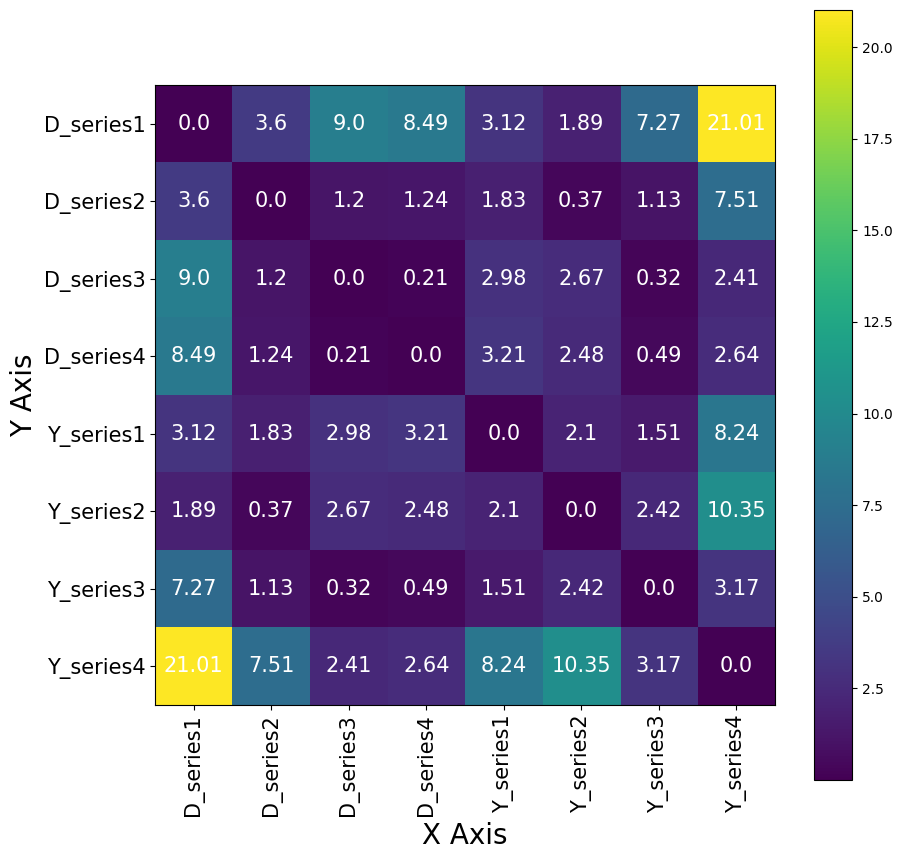

In [ ]:
row_and_column_names = ["D_series1", "D_series2", "D_series3", "D_series4", "Y_series1", "Y_series2", "Y_series3", "Y_series4"
]

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(staM, cmap='viridis')
for i in range(staM.shape[0]):
    for j in range(staM.shape[1]):
        text = plt.text(j, i, np.round(staM[i, j], 2),
                        ha="center", va="center", color="w", fontsize=15)

plt.xticks(ticks=np.arange(len(row_and_column_names)), labels=row_and_column_names, rotation=90,fontsize=15)
plt.yticks(ticks=np.arange(len(row_and_column_names)), labels=row_and_column_names,fontsize=15)
plt.colorbar()
plt.xlabel('X Axis', fontsize=20)
plt.ylabel('Y Axis', fontsize=20)
plt.show()

<ipython-input-22-0c75903a9ca8>:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((df.shape[1], i - 0.5), 0.3, 1, fill=True, color='white', edgecolor='black'))


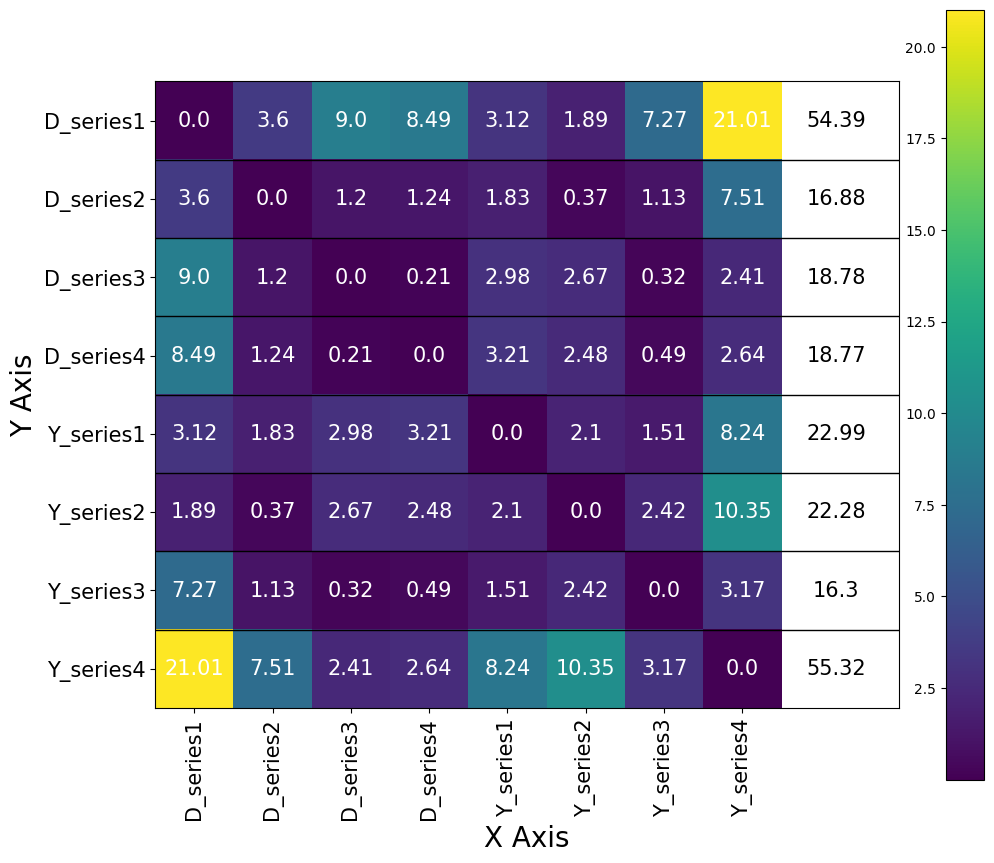

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming staM is your matrix, replace it with your actual matrix
staM = np.array([
[2.125711e-07, 3.603633e+00, 8.996383e+00, 8.494371e+00, 3.123023e+00, 1.888771e+00, 7.269712e+00, 2.101294e+01, 54.388834],
[3.603633e+00, 4.823509e-07, 1.199433e+00, 1.243443e+00, 1.834779e+00, 3.663559e-01, 1.127368e+00, 7.506547e+00, 16.881559],
[8.996383e+00, 1.199433e+00, 3.212933e-07, 2.138170e-01, 2.977620e+00, 2.672913e+00, 3.155046e-01, 2.406640e+00, 18.782311],
[8.494371e+00, 1.243443e+00, 2.138170e-01, 3.901116e-07, 3.209245e+00, 2.482866e+00, 4.856325e-01, 2.640366e+00, 18.769740],
[3.123023e+00, 1.834779e+00, 2.977620e+00, 3.209245e+00, 2.600422e-07, 2.095636e+00, 1.509651e+00, 8.236347e+00, 22.986303],
[1.888771e+00, 3.663559e-01, 2.672913e+00, 2.482866e+00, 2.095636e+00, 3.931840e-07, 2.422579e+00, 1.035020e+01, 22.279322],
[7.269712e+00, 1.127368e+00, 3.155046e-01, 4.856325e-01, 1.509651e+00, 2.422579e+00, 3.198349e-07, 3.170816e+00, 16.301263],
[2.101294e+01, 7.506547e+00, 2.406640e+00, 2.640366e+00, 8.236347e+00, 1.035020e+01, 3.170816e+00, 1.716829e-07, 55.323857]

])

row_and_column_names = ["D_series1", "D_series2", "D_series3", "D_series4", "Y_series1", "Y_series2", "Y_series3", "Y_series4"]

# Create DataFrame and add row and column names
df = pd.DataFrame(staM[:, :8], index=row_and_column_names, columns=row_and_column_names[:8])

# Plot the heatmap
plt.figure(figsize=(12, 10), dpi=100)  # Increase figure size and DPI
plt.imshow(df.values, cmap='viridis')  # Use viridis colormap for better contrast

# Display values inside the heatmap
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        text = plt.text(j, i, np.round(df.values[i, j], 2),  # Display rounded values
                        ha="center", va="center", color="w", fontsize=15)  # Increase font size

# Customize ticks and labels
plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, rotation=90, fontsize=15)
plt.yticks(ticks=np.arange(len(df.index)), labels=df.index, fontsize=15)

# Move colorbar to the left
cbar = plt.colorbar()
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

# Add small squares with last numbers in each row, with reduced width
for i in range(staM.shape[0]):
    plt.gca().add_patch(plt.Rectangle((df.shape[1], i - 0.5), 0.3, 1, fill=True, color='white', edgecolor='black'))
    plt.text(df.shape[1] + 0.2, i, np.round(staM[i, -1], 2),  # Display the last number with two decimals
             ha="center", va="center", color="black", fontsize=15)

# Adjust plot limits to make space for the additional squares
plt.xlim(-0.5, df.shape[1] + 1)
plt.ylim(df.shape[0] - 0.5, -0.5)

# Draw lines between rows
for i in range(1, df.shape[0]):
    plt.axhline(y=i - 0.5, color='black', linewidth=1)

plt.xlabel('X Axis', fontsize=20)
plt.ylabel('Y Axis', fontsize=20)
plt.show()


In [ ]:
row_and_column_names = ["D_series1", "D_series2", "D_series3", "D_series4", "Y_series1", "Y_series2", "Y_series3", "Y_series4"
]

df_sum = pd.DataFrame(staM, index=row_and_column_names, columns=row_and_column_names)

df_sum['sum'] = df_sum.sum(axis=1)

df_sorted = df_sum.sort_values(by='sum', ascending=False)

df_sorted

,D_series1,D_series2,D_series3,D_series4,Y_series1,Y_series2,Y_series3,Y_series4,sum
Y_series4,2.101294e+01,7.506547e+00,2.406640e+00,2.640366e+00,8.236347e+00,1.035020e+01,3.170816e+00,1.716829e-07,55.323857
D_series1,2.125711e-07,3.603633e+00,8.996383e+00,8.494371e+00,3.123023e+00,1.888771e+00,7.269712e+00,2.101294e+01,54.388834
Y_series1,3.123023e+00,1.834779e+00,2.977620e+00,3.209245e+00,2.600422e-07,2.095636e+00,1.509651e+00,8.236347e+00,22.986303
Y_series2,1.888771e+00,3.663559e-01,2.672913e+00,2.482866e+00,2.095636e+00,3.931840e-07,2.422579e+00,1.035020e+01,22.279322
D_series3,8.996383e+00,1.199433e+00,3.212933e-07,2.138170e-01,2.977620e+00,2.672913e+00,3.155046e-01,2.406640e+00,18.782311
D_series4,8.494371e+00,1.243443e+00,2.138170e-01,3.901116e-07,3.209245e+00,2.482866e+00,4.856325e-01,2.640366e+00,18.769740
D_series2,3.603633e+00,4.823509e-07,1.199433e+00,1.243443e+00,1.834779e+00,3.663559e-01,1.127368e+00,7.506547e+00,16.881559
Y_series3,7.269712e+00,1.127368e+00,3.155046e-01,4.856325e-01,1.509651e+00,2.422579e+00,3.198349e-07,3.170816e+00,16.301263
